# Evaluation Metrix  

Memahami Metrics of Classification
Di jobsheet ini, akan dijelaskan terkait berbagai metrik yang digunakan untuk menentukan kinerja pengklasifikasi secara lebih jelas. 

Mari kita mulai dengan mengimpor libraries yang akan digunakan

### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

np.random.seed(42)
sns.set(rc={"figure.figsize": (8, 8)})
sns.set_style("ticks")

### Dataset
Untuk membandingkan metrik yang berbeda, akan menggunakan [Breast Cancer Dataset](https://goo.gl/U2Uwz2) yang disediakan oleh sckit-learn di `dataset` module. Dataset ini digunakan untuk klasifikasi biner antara dua jenis kanker.

In [ ]:
data = load_breast_cancer()
print(data.DESCR[:760]) 

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

 


In [ ]:
print(f"Types of cancer (targets) are {data.target_names}")

Types of cancer (targets) are ['malignant' 'benign']


bagaimana dimensi datanya? terlihat ada **569 contoh** dan setiap contoh memiliki **30 features**.  
yang menjadi **target** variable adalah binary (**0 and 1** untuk `malignant` dan `benign`).   
akan dipertimbangkan `benign` sebagai `positive` class, dan `malignant` sebagi `negative` class.  
Makan dapat difahami sebagai:  
`0 untuk is_not_benign`  
`1 untuk is_benign`

In [ ]:
X = data.data  
y = data.target  
print(f"Shape dari features adalah {X.shape}, dan shape dari target adalah {y.shape}")

Shape of features is (569, 30), and shape of target is (569,)


### Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42, stratify=y)

In [ ]:
y_train[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

### Training and predicting data

Dalam contoh ini, akan menggunakan scikit's Support Vector Machines classifier untuk memprediksi apakah itu kanker jinak.  
`SVC` classifier digunakan dari `sklearn.svm`.

In [ ]:
classifier = svm.SVC(kernel='linear', probability=True, verbose=True)

In [ ]:
classifier.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [ ]:
Now save the prediction results both as probability and as classes.  
**`y_preds`** is a **1D vector** of one of `{0, 1}` values, denoting predictions as malignant and benign, respectively.  
**`y_proba`** is a **2D vector**, where for each example, it contains a vector of length 2,  
`[prob. of malignant, prob. of benign]`

In [ ]:
y_preds = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)

We need to reshape `y_proba` to a 1D vector denoting the probability of having  `benign` cancer.

In [ ]:
y_proba = y_proba[:,1].reshape((y_proba.shape[0],))

In [ ]:
y_proba[:5], y_preds[:5], y_test[:5]

(array([0.99600796, 0.0948797 , 0.99998451, 0.96319115, 0.99999806]),
 array([1, 0, 1, 1, 1]),
 array([1, 0, 1, 1, 1]))

### Confusion Matrix

selanjutnya akan dilakukan perhitungan confusion matrix dan akan diimplementasikan dalam Scikit-learn's [`sklearn.metrics.confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [ ]:
conf = metrics.confusion_matrix(y_test, y_preds)
conf

array([[ 68,   7],
       [  2, 123]])

We can also implement our own confusion matrix.  Here's my implementation.

In [ ]:
def get_confusion_matrix(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [ ]:
conf = get_confusion_matrix(y_test, y_preds)
conf

array([[ 68,   7],
       [  2, 123]])

Text(0.5,83.88,'Predicted label')

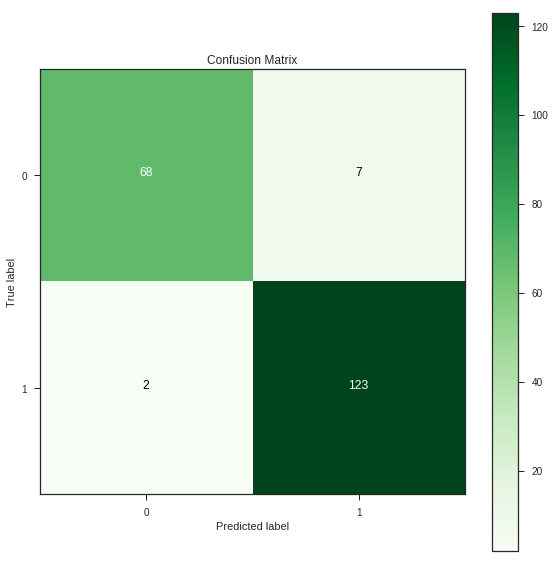

In [ ]:
classes = [0, 1]

plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

dari hasil confusion matrix dapat dilihat jumlah contoh yang diprediksi benar oleh classifier, untuk kedua kelas secara terpisah.  
sehingga didaptkan hasil `True Positives, True Negatives, False Positives, and False Negatives` dari perhitungan confusion matrix.  

In [ ]:

TP = true_pos = 123
TN = true_neg = 68
FP = false_pos = 7
FN = false_neg = 2

### Berbagai tipe *basic metrics*

Sekarang, kita akan menghitung beberapa metrik dasar dari keempat nilai. dan dibutuhkan dictionary untuk menyimpan metrik ini. maka per dibuat dictionary `results`.

In [ ]:
results = {}

#### Accuracy 
jumlah contoh yang diprediksi dengan benar / jumlah total contoh  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/c72ec21ef2505c2d376e96197637fc64f75e5891)

In [ ]:
metric = "ACC"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

ACC is  0.955


#### True Positive Rate
jumlah sampel sebenarnya dan diprediksi sebagai `Positive` / jumlah sampel sebenarnya `Positive`  
juga disebut sebagai **Sensitivity or Recall**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/64d5540cbadeb83f864d7a731b7ab43cccd0f353)


In [ ]:

metric = "TPR"
results[metric] = TP / (TP + FN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  0.984


#### True Negative Rate
jumlah sampel sebenarnya dan diprediksi sebagai `Negative` / jumlah sampel sebenarnya `Negative`  
juga disebut sebagai **Specificity**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/aac65b6586cb61c1268403895012c2a8f19b0c5e)


In [ ]:

metric = "TNR"
results[metric] = TN / (TN + FP)
print(f"{metric} is {results[metric]: .3f}")

TNR is  0.907


#### Positive Predictive Value
jumlah sampel sebenarnya dan diprediksi sebagai `Positive` / jumlah total sampel diprediksi sebagai `Positive`  
Also called **Precision**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/699fcdb880b7f6a92742bc0845b8b60b59806a98)


In [ ]:

metric = "PPV"
results[metric] = TP / (TP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  0.946


#### Negative Predictive Value
number of samples actually and predicted as  `Negative` / total number of samples predicted as `Negative`    
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/b6da0f59faffbc1704974e97847ab4fa599f5521)


In [ ]:
metric = "NPV"
results[metric] = TN / (TN + FN)
print(f"{metric} is {results[metric]: .3f}")

NPV is  0.971


#### F1 score
Rata-rata Harmonic dari Precision dan Recall.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5663ca95d471868169c4e4ea57c936f1b6f4a588)

In [ ]:
metric = "F1"
results[metric] = 2 / (1 / results["PPV"] + 1 / results["TPR"])
print(f"{metric} is {results[metric]: .3f}")

F1 is  0.965


#### Matthew's correlation coefficient
Matthew's coefficient berkisar antara `[-1, 1]`. `0` biasanya memiliki arti prediksi yang benar-benar acak. `1` bermakna perfect classifier, sedangkan nilai negatif (`[-1, 0)`) menunjukkan korelasi negatif antara prediksi dan nilai aktual.   

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

In [ ]:
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
results[metric] = num / den
print(f"{metric} is {results[metric]: .3f}")

MCC is  0.904


### Membandingkan metrik yang telah dihitung

In [ ]:
print(f"Calculated and Actual Accuracy:                          {results['ACC']: .3f}, {metrics.accuracy_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual Precision score:                   {results['PPV']: .3f}, {metrics.precision_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual Recall score:                      {results['TPR']: .3f}, {metrics.recall_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual F1 score:                          {results['F1']: .3f}, {metrics.f1_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual Matthew's correlation coefficient: {results['MCC']: .3f}, {metrics.matthews_corrcoef(y_test, y_preds): .3f}")

Calculated and Actual Accuracy:                           0.955,  0.955
Calculated and Actual Precision score:                    0.946,  0.946
Calculated and Actual Recall score:                       0.984,  0.984
Calculated and Actual F1 score:                           0.965,  0.965
Calculated and Actual Matthew's correlation coefficient:  0.904,  0.904


### ROC curve (Receiver Operating Characteristic curve)
Kurva karakteristik operasi penerima, seperti **ROC curve**, adalah plot grafis yang menggambarkan kemampuan diagnostik sistem pengklasifikasi biner karena ambang batas diskriminasinya bervariasi.  
 ROC curve dibuat dengan memplot **True Positive Rate (TPR)** berlawanan **False Positive Rate (FPR)** dengan berbagai variasi setting pada threshold.    


In [ ]:
def get_roc_curve(y_test, y_proba, delta=0.1):
    """
    Return the True Positive Rates (TPRs), False Positive Rates (FPRs), 
    and the threshold values, seperated by delta.
    """
    thresh = list(np.arange(0, 1, delta)) + [1]
    TPRs = []
    FPRs = []
    y_pred = np.empty(y_proba.shape)
    for th in thresh:
        y_pred[y_proba < th] = 0
        y_pred[y_proba >= th] = 1
        
        
        (TN, FP), (FN, TP) = get_confusion_matrix(y_test, y_pred)
        
        TPR = TP / (TP + FN)  # sensitivity
        FPR = FP / (FP + TN)  # 1 - specificity
        TPRs.append(TPR)
        FPRs.append(FPR)
    return FPRs, TPRs, thresh

disini `delta` adalah perbedaan antara masing-masing ambang batas di mana kurva ROC dihitung

In [ ]:
delta = 0.001
FPRs, TPRs, _ = get_roc_curve(y_test, y_proba, delta)

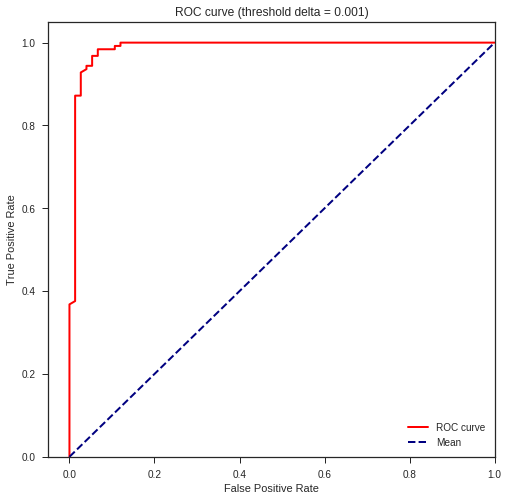

In [ ]:

plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (threshold delta = {delta})')
plt.legend(loc="lower right")
plt.show()

Puncak menuju sudut paling kiri berarti pengklasifikasi mendekati sempurna, sedangkan prediksi acak akan memiliki kurva sebagai garis lurus putus-putus biru. Kurva ROC ini memberi tahu bahwa model yang telah dibuat merupakan classifier yang hampir sempurna, dengan akurasi tinggi

In [ ]:

rand_proba = np.random.random(size=(y_proba.shape))
rand_proba[:5] 

array([0.79654299, 0.18343479, 0.779691  , 0.59685016, 0.44583275])

In [ ]:
FPRs, TPRs, _ = get_roc_curve(y_test, rand_proba, delta)  

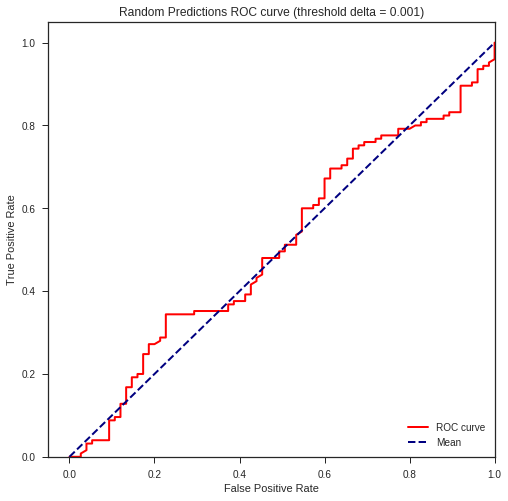

In [ ]:

plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Random Predictions ROC curve (threshold delta = {delta})')
plt.legend(loc="lower right")
plt.show()

Seperti yang dapat dilihat dari plot di atas, prediksi acak memberikan kurva ROC hampir pada rata-rata. Bandingkan dengan kurva sebelumnya, bagaimana model yang dihasilkan memiliki puncak kiri atas, karena kinerjanya yang unggul.

In [ ]:
FPRs, TPRs, _ = metrics.roc_curve(y_test, y_proba)

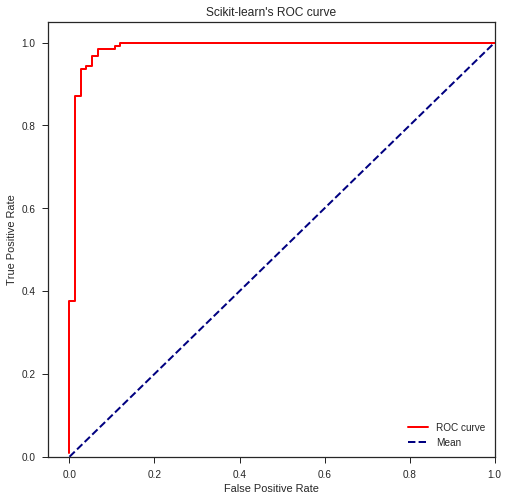

In [ ]:

plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Scikit-learn's ROC curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
FPRs, TPRs, _ = metrics.roc_curve(y_test, rand_proba) 

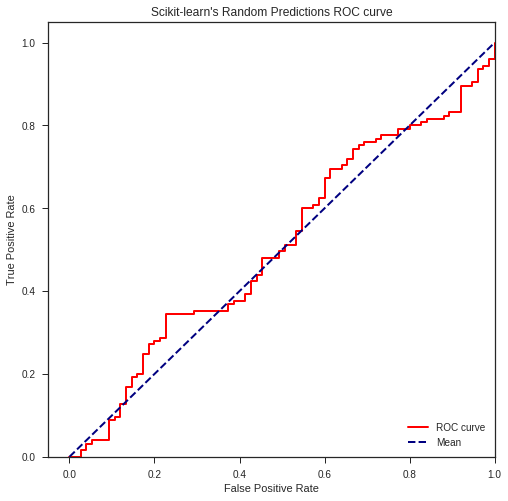

In [ ]:
plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Scikit-learn's Random Predictions ROC curve")
plt.legend(loc="lower right")
plt.show()

### ROC-AUC score
Now, that we know about ROC curve, what it represents, **AUC score** is very easy to understand.  
AUC stands for **Area under the Curve**, which is nothing but the area under the ROC curve formed by the predictions.  
As we saw, a totally random prediction will have AUC score `0.5`, while a perfect classifier will have AUC score of `1`. 

In [ ]:
auc_score = metrics.roc_auc_score(y_test, y_proba)
print(f"Scikit's ROC-AUC score of SVC model is {auc_score: .4f}")

Scikit's ROC-AUC score of SVC model is  0.9872


In [ ]:
def get_roc_auc_score(y_test, y_proba):
    
    FPRs, TPRs, _ = get_roc_curve(y_test, y_proba)
    FPRs.reverse()
    TPRs.reverse()
    x1, y1 = FPRs[0], TPRs[0]
    auc = 0.0
    prev = 0.0

    diffs = [FPRs[i] - FPRs[i-1] for i in range(1, len(FPRs))]
    for x, y in zip(diffs, TPRs[1:]):
        auc += (x * y1)
        auc += (x * (y - y1)/2) 
        y1 = y
    return auc

In [ ]:
auc_score = get_roc_auc_score(y_test, y_proba)
print(f"Our ROC-AUC score of SVC model is {auc_score: .4f}")

Our ROC-AUC score of SVC model is  0.9870


In [ ]:
auc_score = metrics.roc_auc_score(y_test, rand_proba)
print(f"Scikit's ROC-AUC score of random predictions is: {auc_score: .4f}")
auc_score = get_roc_auc_score(y_test, rand_proba)
print(f"Our ROC-AUC score of random predictions is:      {auc_score: .4f}")

Scikit's ROC-AUC score of random predictions is:  0.5111
Our ROC-AUC score of random predictions is:       0.5080
